<a href="https://colab.research.google.com/github/ShwetaBaranwal/GAN/blob/master/Understanding_CycleGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import tqdm
from matplotlib.pyplot import imshow, imread
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import glob
import os
import itertools
from torch.autograd import Variable


Downloading dataset

In [2]:
!pwd

/content


In [ ]:
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip -O ./monet2photo.zip
!unzip ./monet2photo.zip -d .
!rm ./monet2photo.zip

In [4]:
!mkdir -p "./monet2photo/train" "./monet2photo/test"
!mv "./monet2photo/trainA" "./monet2photo/train/A"
!mv "./monet2photo/trainB" "./monet2photo/train/B"
!mv "./monet2photo/testA" "./monet2photo/test/A"
!mv "./monet2photo/testB" "./monet2photo/test/B"

In [5]:
image_trainA = Image.open('./monet2photo/train/A/00001.jpg')
image_trainB = Image.open('./monet2photo/train/B/2013-11-08 16:45:24.jpg')
image_testA = Image.open('./monet2photo/test/A/00010.jpg')
image_testB = Image.open('./monet2photo/test/B/2014-08-01 17:41:55.jpg')

(256, 256)
(256, 256)
(256, 256)
(256, 256)


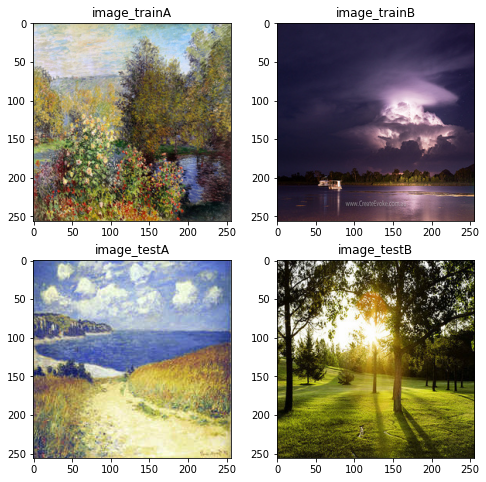

In [6]:
f, axarr = plt.subplots(2,2, figsize=(8,8))
axarr[0,0].imshow(image_trainA)
axarr[0,0].set_title('image_trainA')
print(image_trainA.size)

axarr[0,1].imshow(image_trainB)
axarr[0,1].set_title('image_trainB')
print(image_trainB.size)

axarr[1,0].imshow(image_testA)
axarr[1,0].set_title('image_testA')
print(image_testA.size)

axarr[1,1].imshow(image_testB)
axarr[1,1].set_title('image_testB')
print(image_testB.size)


modifying image with channel dim

In [7]:
#using numpy
print(np.array(image_trainA).shape)
#using tensor
print(transforms.ToTensor()(image_trainA).shape)

(256, 256, 3)
torch.Size([3, 256, 256])


In [8]:
print (len(glob.glob('./monet2photo/train/A/' + "/*.*")))
print (len(glob.glob('./monet2photo/train/B/' + "/*.*")))
print (len(glob.glob('./monet2photo/test/A/' + "/*.*")))
print (len(glob.glob('./monet2photo/test/B/' + "/*.*")))

1072
6287
121
751


Dataset loader

In [9]:
class ImageDatasetModule(Dataset):
  def __init__(self, path_, transform_, mode="train"):

    self.files_A = sorted(glob.glob(os.path.join(path_, "%s/A" % mode) + "/*.*"))  #glob module finds all the pathnames matching a specified pattern
    self.files_B = sorted(glob.glob(os.path.join(path_, "%s/B" % mode) + "/*.*"))
    self.transform = transforms.Compose(transforms_)
  
  def __len__(self):
        return max(len(self.files_A), len(self.files_B))

  def __getitem__(self, idx):
    input_A = Image.open(self.files_A[idx % len(self.files_A)])
    input_B = Image.open(self.files_B[idx % len(self.files_B)])
    input_A = self.transform(input_A)
    input_B = self.transform(input_B)

    return {"A": input_A, "B": input_B}


Checking if ImageDatasetModule class is working:

In [10]:
transforms_ = [transforms.Resize((128,128),interpolation=Image.NEAREST),
               transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
i = ImageDatasetModule('./monet2photo/', transforms_)

In [11]:
i.__getitem__(1)['A'].shape

torch.Size([3, 128, 128])

Creating test and train image generator

In [12]:
img_transforms = [transforms.Resize((128,128),interpolation=Image.NEAREST),
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
img_path = './monet2photo/'
TRAIN_BATCH_SIZE = 16

train_dataset = ImageDatasetModule(img_path, img_transforms)
train_dataloader = DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, shuffle=True)


test_dataset = ImageDatasetModule(img_path, img_transforms, mode='test')
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle=False)


Showing a batch:

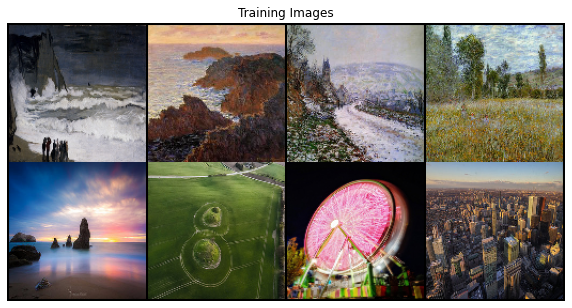

In [13]:
#train batch
b_ = next(iter(train_dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(torch.cat((b_['A'][:4], b_['B'][:4]), 2), padding=2, normalize=True),(1,2,0)))   #tensor to numpy is req for imshow.

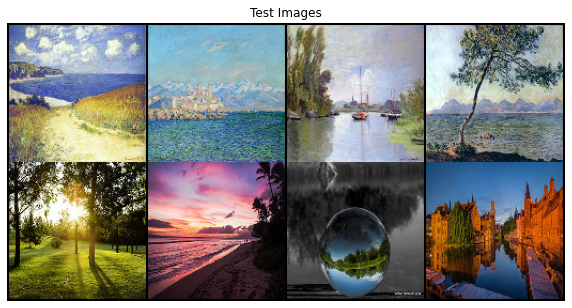

In [14]:
#test batch
b_ = next(iter(test_dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(make_grid(torch.cat((b_['A'], b_['B']), 2), padding=2, normalize=True),(1,2,0)))   #tensor to numpy is req for imshow.

Generator network:

In [61]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [62]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


Discriminator network:


In [63]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

Setting up model:

In [64]:
input_shape = (3, 128, 128)
n_residual_blocks = 9

In [86]:
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)

In [87]:
G_AB

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

In [88]:
#printing count of parameters
sum(p.numel() for p in G_AB.parameters() if p.requires_grad)

11378179

In [89]:
s=0
for name, parameter in G_AB.named_parameters():
  print (name, parameter.numel())
  s += parameter.numel()
print (s)

model.1.weight 9408
model.1.bias 64
model.4.weight 73728
model.4.bias 128
model.7.weight 294912
model.7.bias 256
model.10.block.1.weight 589824
model.10.block.1.bias 256
model.10.block.5.weight 589824
model.10.block.5.bias 256
model.11.block.1.weight 589824
model.11.block.1.bias 256
model.11.block.5.weight 589824
model.11.block.5.bias 256
model.12.block.1.weight 589824
model.12.block.1.bias 256
model.12.block.5.weight 589824
model.12.block.5.bias 256
model.13.block.1.weight 589824
model.13.block.1.bias 256
model.13.block.5.weight 589824
model.13.block.5.bias 256
model.14.block.1.weight 589824
model.14.block.1.bias 256
model.14.block.5.weight 589824
model.14.block.5.bias 256
model.15.block.1.weight 589824
model.15.block.1.bias 256
model.15.block.5.weight 589824
model.15.block.5.bias 256
model.16.block.1.weight 589824
model.16.block.1.bias 256
model.16.block.5.weight 589824
model.16.block.5.bias 256
model.17.block.1.weight 589824
model.17.block.1.bias 256
model.17.block.5.weight 589824
m

In [90]:
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

In [91]:
D_A

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [92]:
D_A.output_shape

(1, 8, 8)

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_AB = G_AB.to(device)
G_BA = G_BA.to(device)
D_A = D_A.to(device)
D_B = D_B.to(device)

In [94]:
print(device)

cuda


In [95]:
#Loss
criterion_GAN = nn.MSELoss()
criterion_identity = nn.L1Loss()
criterion_cycle = nn.L1Loss()

In [96]:
#optimizer
LEARNING_RATE = 0.0003
optimizer_G = Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=LEARNING_RATE)
optimizer_D_A = Adam(D_A.parameters(), lr=LEARNING_RATE)
optimizer_D_B = Adam(D_B.parameters(), lr=LEARNING_RATE)

In [76]:
#Learning rate update schedulers
scheduler_G = StepLR(optimizer_G, step_size=2, gamma=0.1)
scheduler_D_A = StepLR(optimizer_D_A, step_size=2, gamma=0.1)
scheduler_D_B = StepLR(optimizer_D_B, step_size=2, gamma=0.1)


In [97]:
Tensor = torch.cuda.FloatTensor

In [98]:
N_EPOCH = 10
G_AB.train()
G_BA.train()
for i in range(N_EPOCH):
  for bi, d in enumerate(tqdm.notebook.tqdm(train_dataloader, desc="Iteration")): 
    real_A = d['A'].to(device, dtype = torch.float)
    real_B = d['B'].to(device, dtype = torch.float)

    valid = torch.tensor(np.ones((real_A.size(0), *D_A.output_shape)), requires_grad=False).to(device, dtype = torch.float)
    fake = torch.tensor(np.zeros((real_A.size(0), *D_A.output_shape)), requires_grad=False).to(device, dtype = torch.float)


    # real_A = Variable(d["A"].type(Tensor))
    # real_B = Variable(d["B"].type(Tensor))

    # # Adversarial ground truths
    # valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
    # fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

    optimizer_G.zero_grad()

    #GAN Loss
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
    loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2

    #Cycle Loss
    recov_B = G_AB(fake_A)
    recov_A = G_BA(fake_B)
    loss_cycle_AB = criterion_cycle(recov_B, real_B)
    loss_cycle_BA = criterion_cycle(recov_A, real_A)
    loss_cycle = (loss_cycle_AB + loss_cycle_BA)/2

    #Identity Loss
    iden_B = G_AB(real_B)
    iden_A = G_BA(real_A)
    loss_identity_B = criterion_identity(iden_B, real_B)
    loss_identity_A = criterion_identity(iden_A, real_A)
    loss_identity = (loss_identity_B + loss_identity_A)/2

    #Total Loss
    loss_G = loss_GAN + 15.0*loss_cycle + 5.0*loss_identity

    loss_G.backward()
    # loss_G.backward(retain_graph=True)
    optimizer_G.step()


    #loss D_A
    optimizer_D_A.zero_grad()
    loss_real_D_A = criterion_GAN(D_A(real_A), valid)
    loss_fake_D_A = criterion_GAN(D_A(fake_A.detach()), fake)
    loss_D_A = (loss_real_D_A + loss_fake_D_A)/2
    loss_D_A.backward()
    optimizer_D_A.step()

    #loss D_B
    optimizer_D_B.zero_grad()
    loss_real_D_B = criterion_GAN(D_B(real_B), valid)
    loss_fake_D_B = criterion_GAN(D_B(fake_B.detach()), fake)
    loss_D_B = (loss_real_D_B + loss_fake_D_B)/2
    loss_fake_D_B.backward()
    optimizer_D_B.step()

    # scheduler_G.step()
    # scheduler_D_A.step()
    # scheduler_D_B.step()

    if bi%100==0:
      print("epoch: {}, batch: {}, loss_G: {}, loss_D_A: {}, loss_D_B: {}".format(i, bi, loss_G.item(), loss_D_A.item(), loss_D_B.item()))


      

epoch: 0, batch: 0, loss_G: 12.40469741821289, loss_D_A: 0.8072897791862488, loss_D_B: 0.7197793126106262
epoch: 0, batch: 100, loss_G: 6.503653526306152, loss_D_A: 0.06102702394127846, loss_D_B: 0.5044490098953247
epoch: 0, batch: 200, loss_G: 5.493490695953369, loss_D_A: 0.150891974568367, loss_D_B: 0.5001654624938965
epoch: 0, batch: 300, loss_G: 5.571393013000488, loss_D_A: 0.06685419380664825, loss_D_B: 0.5021594166755676



epoch: 1, batch: 0, loss_G: 5.87082052230835, loss_D_A: 0.09720812737941742, loss_D_B: 0.4977673590183258
epoch: 1, batch: 100, loss_G: 5.695494651794434, loss_D_A: 0.05121868848800659, loss_D_B: 0.5037363767623901
epoch: 1, batch: 200, loss_G: 5.110613822937012, loss_D_A: 0.07505176216363907, loss_D_B: 0.4988437592983246
epoch: 1, batch: 300, loss_G: 5.362573623657227, loss_D_A: 0.08836716413497925, loss_D_B: 0.49811089038848877



epoch: 2, batch: 0, loss_G: 5.298379421234131, loss_D_A: 0.10483458638191223, loss_D_B: 0.4993734061717987
epoch: 2, batch: 100, loss_G: 5.224193572998047, loss_D_A: 0.09878452122211456, loss_D_B: 0.4985153377056122
epoch: 2, batch: 200, loss_G: 5.628134727478027, loss_D_A: 0.043056994676589966, loss_D_B: 0.49899056553840637
epoch: 2, batch: 300, loss_G: 5.682146072387695, loss_D_A: 0.07831156998872757, loss_D_B: 0.5033240914344788



epoch: 3, batch: 0, loss_G: 4.956000328063965, loss_D_A: 0.09089495241641998, loss_D_B: 0.4987843334674835
epoch: 3, batch: 100, loss_G: 5.213194847106934, loss_D_A: 0.13314390182495117, loss_D_B: 0.4980500340461731
epoch: 3, batch: 200, loss_G: 5.036851406097412, loss_D_A: 0.09425485134124756, loss_D_B: 0.4991542100906372
epoch: 3, batch: 300, loss_G: 5.568842887878418, loss_D_A: 0.07809881865978241, loss_D_B: 0.49759331345558167



epoch: 4, batch: 0, loss_G: 5.147689342498779, loss_D_A: 0.07996486127376556, loss_D_B: 0.4993396997451782
epoch: 4, batch: 100, loss_G: 5.031188011169434, loss_D_A: 0.20288492739200592, loss_D_B: 0.4971332252025604
epoch: 4, batch: 200, loss_G: 4.919153213500977, loss_D_A: 0.13251975178718567, loss_D_B: 0.49891120195388794
epoch: 4, batch: 300, loss_G: 4.965769290924072, loss_D_A: 0.09100031852722168, loss_D_B: 0.4986322820186615



epoch: 5, batch: 0, loss_G: 4.785219192504883, loss_D_A: 0.07866742461919785, loss_D_B: 0.4972058832645416
epoch: 5, batch: 100, loss_G: 4.928535461425781, loss_D_A: 0.08083520829677582, loss_D_B: 0.49915871024131775
epoch: 5, batch: 200, loss_G: 4.666046142578125, loss_D_A: 0.20258978009223938, loss_D_B: 0.49881502985954285
epoch: 5, batch: 300, loss_G: 4.804933547973633, loss_D_A: 0.16188333928585052, loss_D_B: 0.5027746558189392



epoch: 6, batch: 0, loss_G: 4.637931823730469, loss_D_A: 0.2221585214138031, loss_D_B: 0.49946328997612
epoch: 6, batch: 100, loss_G: 4.585590362548828, loss_D_A: 0.0920882374048233, loss_D_B: 0.500230073928833
epoch: 6, batch: 200, loss_G: 4.643551826477051, loss_D_A: 0.0537533313035965, loss_D_B: 0.5027191638946533
epoch: 6, batch: 300, loss_G: 4.528433799743652, loss_D_A: 0.116044782102108, loss_D_B: 0.5002584457397461



epoch: 7, batch: 0, loss_G: 5.071579456329346, loss_D_A: 0.15778768062591553, loss_D_B: 0.5014897584915161
epoch: 7, batch: 100, loss_G: 4.424934387207031, loss_D_A: 0.07038863003253937, loss_D_B: 0.49725213646888733
epoch: 7, batch: 200, loss_G: 4.653801918029785, loss_D_A: 0.10084190964698792, loss_D_B: 0.5076344609260559
epoch: 7, batch: 300, loss_G: 4.6527910232543945, loss_D_A: 0.19051384925842285, loss_D_B: 0.5008525848388672



epoch: 8, batch: 0, loss_G: 4.409323692321777, loss_D_A: 0.10462358593940735, loss_D_B: 0.5036492347717285
epoch: 8, batch: 100, loss_G: 4.556088447570801, loss_D_A: 0.18680697679519653, loss_D_B: 0.49925899505615234
epoch: 8, batch: 200, loss_G: 4.782646656036377, loss_D_A: 0.1123608648777008, loss_D_B: 0.49708375334739685
epoch: 8, batch: 300, loss_G: 5.1590447425842285, loss_D_A: 0.11611635237932205, loss_D_B: 0.50070720911026



epoch: 9, batch: 0, loss_G: 4.549685955047607, loss_D_A: 0.12568411231040955, loss_D_B: 0.5024937987327576
epoch: 9, batch: 100, loss_G: 4.745129585266113, loss_D_A: 0.13673429191112518, loss_D_B: 0.512944221496582
epoch: 9, batch: 200, loss_G: 4.468272686004639, loss_D_A: 0.08327687531709671, loss_D_B: 0.4983747899532318
epoch: 9, batch: 300, loss_G: 4.314681053161621, loss_D_A: 0.0646071806550026, loss_D_B: 0.49872061610221863



In [99]:
td = iter(test_dataloader)

In [100]:
imgs = next(td)
G_AB.eval()
G_BA.eval()

real_A = Variable(imgs["A"].type(Tensor))
fake_B = G_AB(real_A)
recov_A = G_BA(fake_B)

real_B = Variable(imgs["B"].type(Tensor))
fake_A = G_BA(real_B)
recov_B = G_AB(fake_A)

In [101]:
fake_B.size()

torch.Size([4, 3, 128, 128])

In [102]:
# Arange images along x-axis
real_A = make_grid(real_A, nrow=4, normalize=True)
fake_B = make_grid(fake_B, nrow=4, normalize=True)
recov_A = make_grid(recov_A, nrow=4, normalize=True)

# Arange images along y-axis
image_grid_1 = torch.cat((real_A, fake_B, recov_A), 1).detach()
   

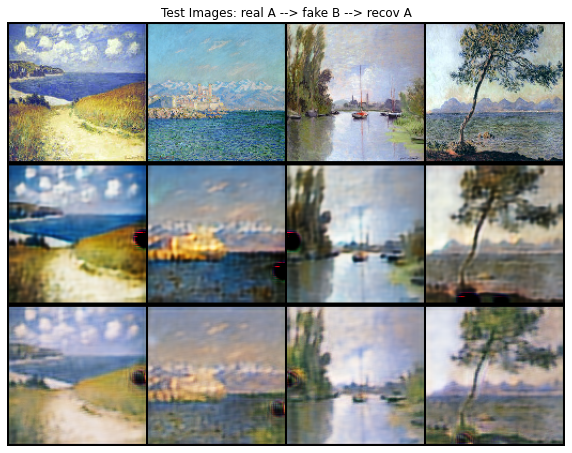

In [103]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Test Images: real A --> fake B --> recov A")
plt.imshow(np.transpose(image_grid_1.cpu(),(1,2,0)))   #tensor to numpy is req for imshow.  

In [104]:
real_B = make_grid(real_B, nrow=4, normalize=True)
fake_A = make_grid(fake_A, nrow=4, normalize=True)
recov_B = make_grid(recov_B, nrow=4, normalize=True)

# Arange images along y-axis
image_grid_2 = torch.cat((real_B, fake_A, recov_B), 1).detach()

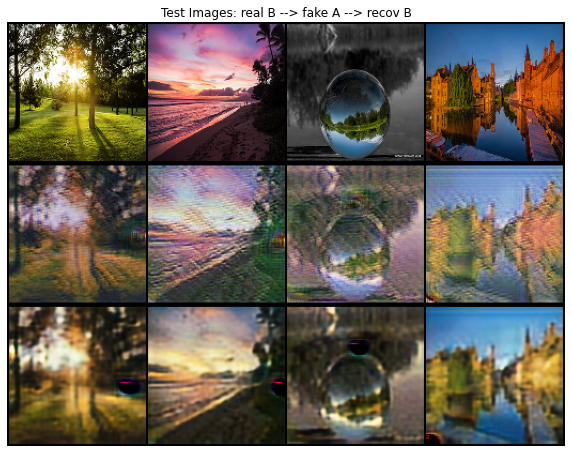

In [105]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Test Images: real B --> fake A --> recov B")
plt.imshow(np.transpose(image_grid_2.cpu(),(1,2,0)))   #tensor to numpy is req for imshow.  